In [3]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle5 as pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
import tensorflow as tf
seed=2022
tf.random.set_seed(seed)
np.random.seed(seed)

## 기타 데이터 가공

In [6]:
df2=pd.read_csv('/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/csv파일/train_df_최종본_15세이상_65세미만.csv')
df2

,uuid,cough_detected,SNR,gender,man,respiratory_condition,fever_muscle_pain,COVID-19,healthy,symptomatic,15세미만,15세이상65세미만,65세이상
0,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,0.9301,20.146058,male,1,1,0,0,1,0,0,1,0
1,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,0.9968,13.146502,male,1,0,0,0,1,0,0,1,0
2,001e2f19-d81c-4029-b33c-d2db56b23a4a,0.7811,12.566406,male,1,1,0,0,1,0,0,1,0
3,00291cce-36a0-4a29-9e2d-c1d96ca17242,0.9883,14.603851,male,1,0,0,0,1,0,0,1,0
4,0029d048-898a-4c70-89c7-0815cdcf7391,1.0000,9.624196,male,1,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,81234f36-5600-4a20-b1b3-3465686b0d4f,0.0558,3.695154,female,0,1,1,1,0,0,0,1,0
572,812a0f06-9e05-459e-84fc-2654bbb8bf9c,1.0000,13.250514,female,0,0,0,1,0,0,0,1,0
573,84f4ba06-bcc4-4a68-bb08-725c486524d7,0.7291,7.357569,female,0,1,0,1,0,0,0,1,0
574,84f7f9eb-ce07-4ace-8c02-d83360a25db4,1.0000,8.764202,female,0,0,1,1,0,0,0,1,0


In [7]:
X2=[]
y2=[]
for i in range(len(df2)):
  for _ in range(4):     # 오그멘테이션 숫자만큼 range()안에 넣어줘야됨
    X2.append(list(df2.iloc[i, [4,5,6,7]].values))

In [8]:
X2=pd.DataFrame(X2)
X2

,0,1,2,3
0,1,1,0,0
1,1,1,0,0
2,1,1,0,0
3,1,1,0,0
4,1,0,0,0
...,...,...,...,...
2299,0,0,1,1
2300,0,0,0,1
2301,0,0,0,1
2302,0,0,0,1


## 음성 데이터 가공

In [9]:
df=pd.read_csv('/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/mfcc/Y_data_1516.csv')
df

,COVID-19,healthy
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
2299,1,0
2300,1,0
2301,1,0
2302,1,0


In [10]:
y=np.array(df.iloc[:,0].values)

In [11]:
with open("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/mfcc/result_1565_data.pickle","rb") as fr:
    data = pickle.load(fr)

length=[]
for i in range(len(data)):
    length.append(data[i].shape[1])
    
min_len=min(length)

result=[]
for i in range(len(data)):
    result.append(data[i][:,:min_len])
    
result_data=np.array(result)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(
    result_data, X2, stratify = X2, test_size = 0.2
)

In [13]:
features_train = Y_train.iloc[:,:-1].values
y_data_train = Y_train.iloc[:,-1].values
features_test = Y_test.iloc[:,:-1].values
y_data_test = Y_test.iloc[:,-1].values

In [18]:
img_input=Input(shape=(30,901,1), name='cough_sound')
other_input=Input(shape=(3), name='other_data')

# 기침 데이터 처리 모델 구현
x_1=Conv2D(256, kernel_size=(3,3), activation='relu')(img_input)
x_1=Conv2D(256, (3,3), activation='relu')(x_1)
x_1=MaxPooling2D()(x_1)
x_1=Dropout(0.25)(x_1)
x_1=Conv2D(128, (3,3), activation='relu')(x_1)
x_1=Conv2D(128, (3,3), activation='relu')(x_1)
x_1=MaxPooling2D()(x_1)
x_1=Flatten()(x_1)
x_1=Dense(128, activation='relu')(x_1)
x_1=Dropout(0.5)(x_1)
x_1=Dense(64, activation='relu')(x_1)
x_1=Dropout(0.5)(x_1)

x_2=Dense(128, activation='relu')(other_input)
x_2=Dense(52, activation='relu')(x_2)

x=Concatenate()([x_1,x_2])

result=Dense(1, activation='sigmoid', name='test_result')(x)

model = Model([img_input,other_input], result)

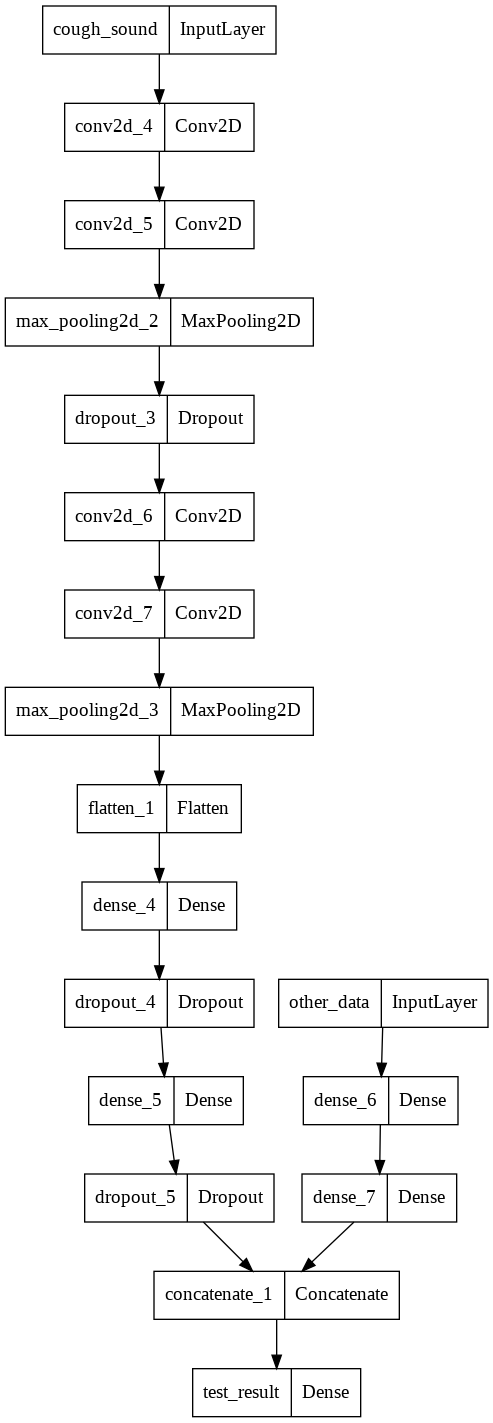

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
model_path='best-covid-complex_young.h5'
mc=ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
es=EarlyStopping(patience=10)

In [21]:
model.compile('adam', loss=['binary_crossentropy'], metrics={'test_result':'acc'})

hist=model.fit(
    [X_train, features_train], y_data_train, validation_split=0.2, epochs=50, batch_size=50, callbacks=[mc, es]
)

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 1.7422 - acc: 0.5719
Epoch 1: val_loss improved from inf to 0.66782, saving model to best-covid-complex_young.h5
30/30 [==============================] - 62s 1s/step - loss: 1.7422 - acc: 0.5719 - val_loss: 0.6678 - val_acc: 0.6287
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.6573 - acc: 0.6221
Epoch 2: val_loss improved from 0.66782 to 0.65449, saving model to best-covid-complex_young.h5
30/30 [==============================] - 33s 1s/step - loss: 0.6573 - acc: 0.6221 - val_loss: 0.6545 - val_acc: 0.6287
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 0.6475 - acc: 0.6201
Epoch 3: val_loss improved from 0.65449 to 0.64957, saving model to best-covid-complex_young.h5
30/30 [==============================] - 32s 1s/step - loss: 0.6475 - acc: 0.6201 - val_loss: 0.6496 - val_acc: 0.6287
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: 0.6451 - acc: 0.6153
Epo

In [22]:
best_model=load_model(model_path)
best_model.evaluate([X_test, features_test], y_data_test,)

15/15 [==============================] - 7s 286ms/step - loss: 0.6400 - acc: 0.6226


[0.6399577856063843, 0.622559666633606]

In [23]:
from sklearn.metrics import confusion_matrix
y_train_pred=best_model.predict([X_test, features_test])
yhat=[]
for data in y_train_pred:
  if data>=0.5:
    yhat.append(1)
  else:
    yhat.append(0)
print(yhat)

[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 

In [24]:
cf = confusion_matrix(y_data_test, yhat)
print(cf)

[[185  45]
 [129 102]]


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score
p = precision_score(y_data_test, yhat)
print(p)
r = recall_score(y_data_test, yhat)
print(r)
f1 = f1_score(y_data_test, yhat)
print(f1)

0.6938775510204082
0.44155844155844154
0.5396825396825397
